----- Ejecutando k-Means: 0.10 segundos, Calinski-Harabasz Index: 1017.578, Silhouette Coefficient: 0.23347
Tamaño de cada cluster:
0:  1338 (40.28%)
4:  1057 (31.82%)
1:   528 (15.89%)
2:   227 ( 6.83%)
3:   172 ( 5.18%)
---------- Heatmap...
---------- Scatter matrix...
---------- Boxplots...
---------- MDS...


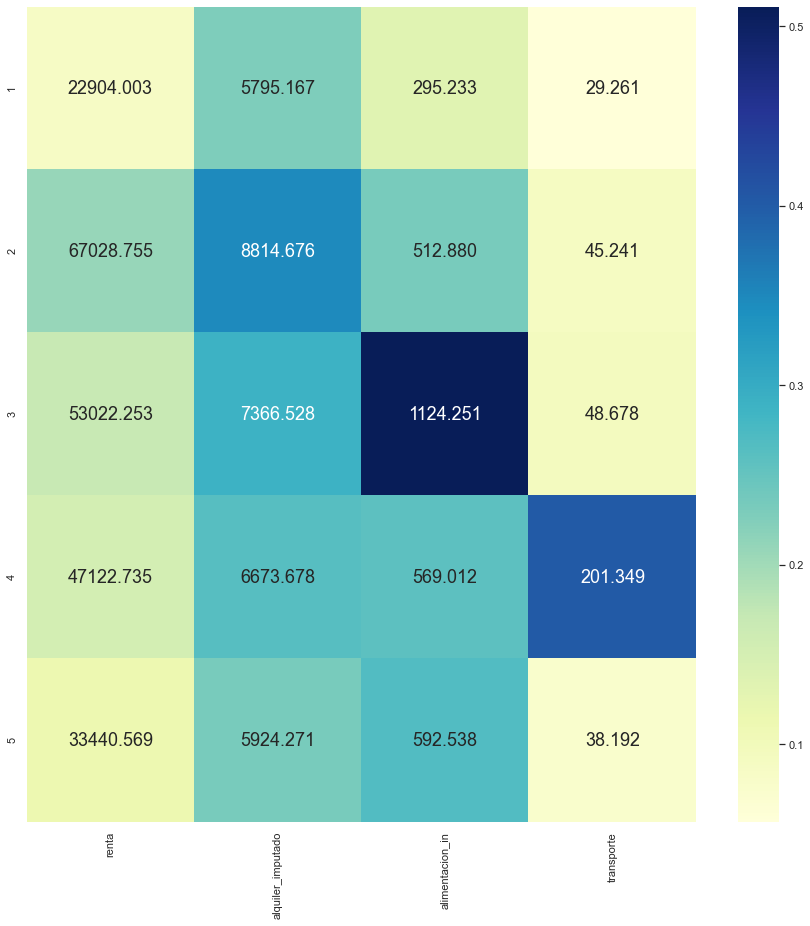

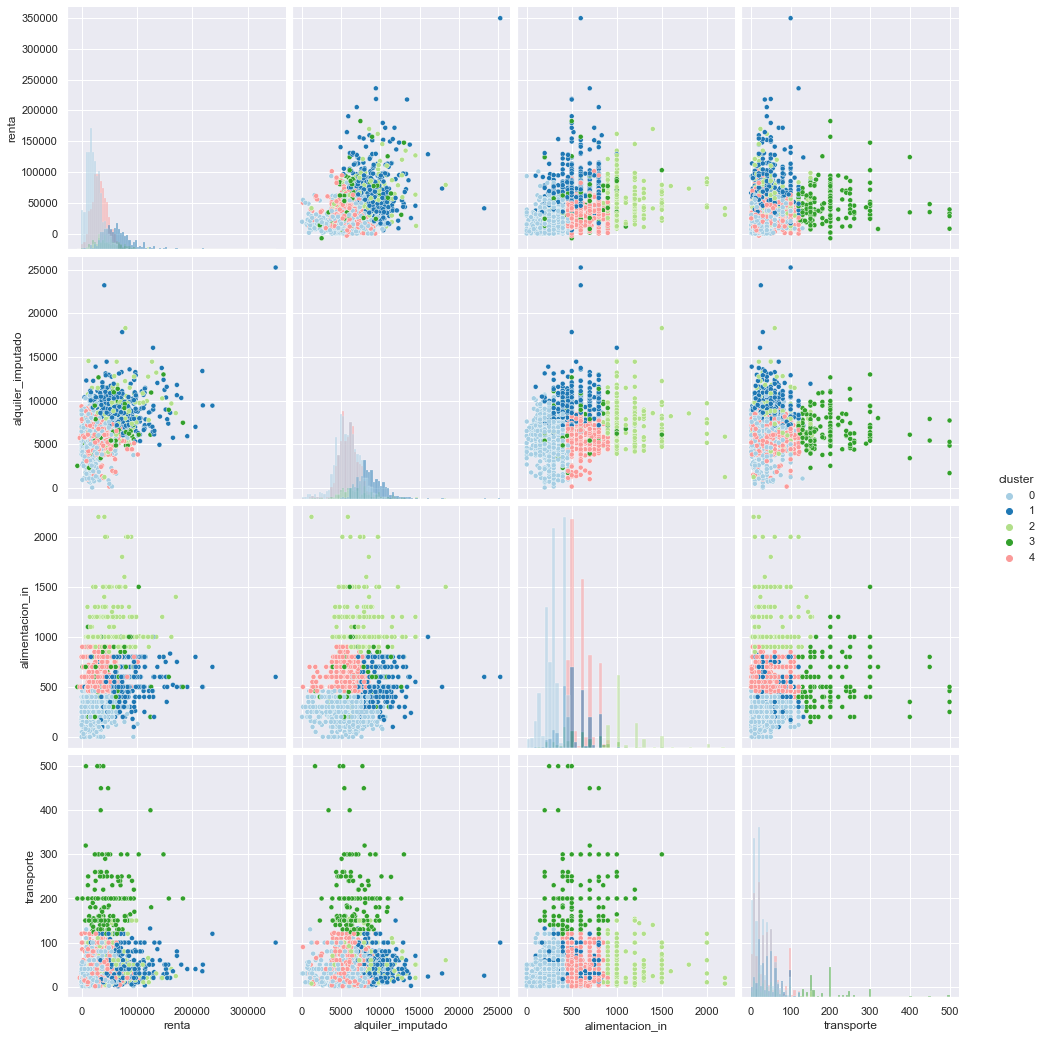

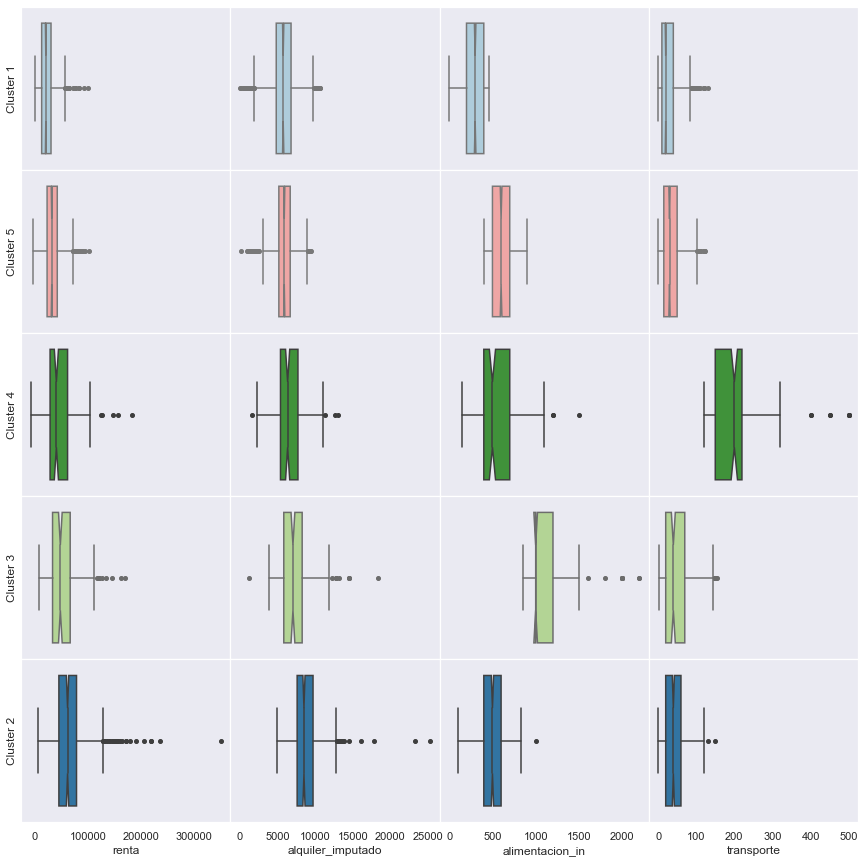

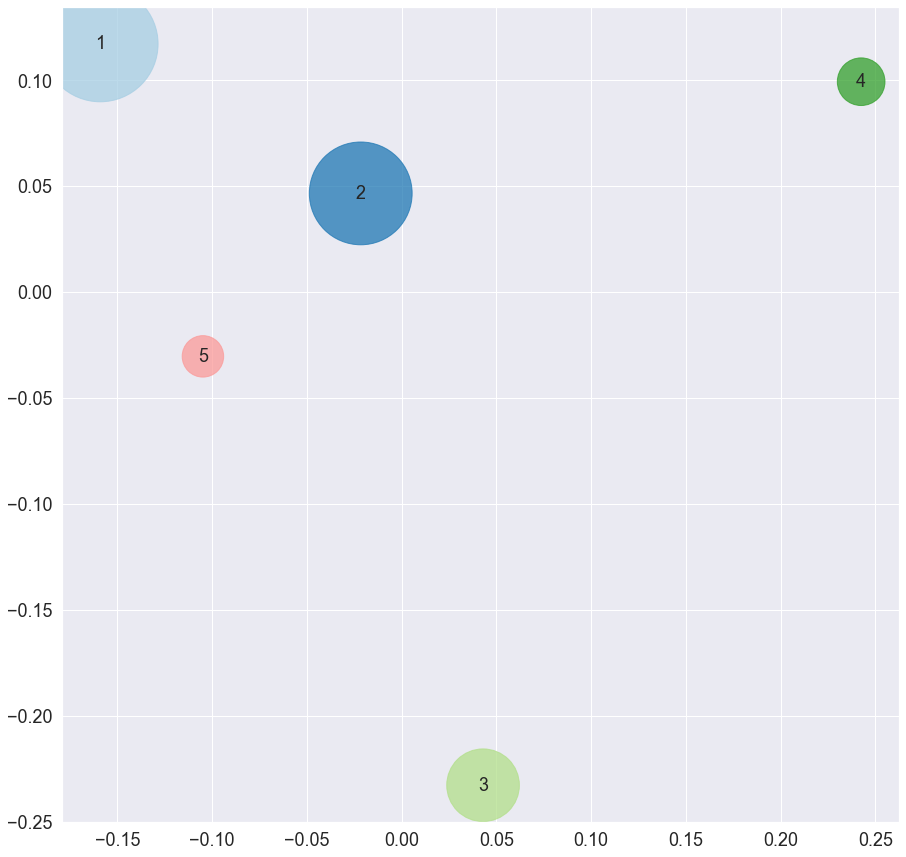

In [2]:
# -*- coding: utf-8 -*-
"""
Autor:
    Jorge Casillas
Fecha:
    Noviembre/2021
Contenido:
    Ejemplo de uso de clustering en Python
    Inteligencia de Negocio
    Grado en Ingeniería Informática
    Universidad de Granada
"""

'''
Documentación sobre clustering en Python:
    http://scikit-learn.org/stable/modules/clustering.html
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/
    http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
    https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/
'''

import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.manifold import MDS
from math import floor
import seaborn as sns

def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

datos = pd.read_csv('datos_hogar_2020.csv')

'''
for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)
#'''

# Se pueden reemplazar los valores desconocidos por un número
# datos = datos.replace(np.NaN,0)

# O imputar, por ejemplo con la media      
for col in datos:
    if col != 'DB040':
        datos[col].fillna(datos[col].mean(), inplace=True)
      
# Seleccionar casos
subset = datos.loc[(datos['HY030N']>0) & (datos['HC030_F']==1)] #solo los que se conoce el alquiler imputado y gasto en transporte público

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HY030N": "alquiler_imputado", "HC010": "alimentacion_in", "HC030": "transporte"})
usadas = ['renta','alquiler_imputado','alimentacion_in','transporte']

n_var = len(usadas)
X = subset[usadas]

# eliminar outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

# normalizamos
X_normal = X.apply(norm_to_zero_one)

print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=5, n_init=5, random_state=123456)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal,subset['DB090']) #se usa DB090 como peso para cada objeto (factor de elevación)
tiempo = time.time() - t
print(": {:.2f} segundos, ".format(tiempo), end='')
metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')

# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
muestra_silhoutte = 0.2 if (len(X) > 10000) else 1.0
   
metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhoutte*len(X)), random_state=123456)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))

# se convierte la asignación de clusters a DataFrame
clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.iteritems():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
centers_desnormal = centers.copy()

# se convierten los centros a los rangos originales antes de normalizar
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

print("---------- Heatmap...")
centers.index += 1
hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
hm.set_ylim(len(centers),0)
hm.figure.set_size_inches(15,15)
hm.figure.savefig("centroides.png")
centers.index -= 1

k = len(size)
colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)

#'''
print("---------- Scatter matrix...")
# se añade la asignación de clusters como columna a X
X_kmeans = pd.concat([X, clusters], axis=1)
#'''
sns.set()
variables = list(X_kmeans)
variables.remove('cluster')
sns_plot = sns.pairplot(X_kmeans, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
sns_plot.fig.set_size_inches(15,15)
sns_plot.savefig("scatter.png")
#'''

print("---------- Boxplots...")

fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
fig.subplots_adjust(wspace=0,hspace=0)

centers_sort = centers.sort_values(by=['renta']) #ordenamos por renta para el plot

rango = []
for j in range(n_var):
   rango.append([X_kmeans[usadas[j]].min(),X_kmeans[usadas[j]].max()])

for i in range(k):
    c = centers_sort.index[i]
    dat_filt = X_kmeans.loc[X_kmeans['cluster']==c]
    for j in range(n_var):
        #ax = sns.kdeplot(x=dat_filt[usadas[j]], label="", shade=True, color=colors[c], ax=axes[i,j])
        ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

        if (i==k-1):
            axes[i,j].set_xlabel(usadas[j])
        else:
            axes[i,j].set_xlabel("")
        
        if (j==0):
           axes[i,j].set_ylabel("Cluster "+str(c+1))
        else:
            axes[i,j].set_ylabel("")
        
        axes[i,j].set_yticks([])
        axes[i,j].grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
        axes[i,j].grid(axis='y', b=False)
        
        ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

fig.set_size_inches(15,15)
fig.savefig("boxplots.png")

print("---------- MDS...")
mds = MDS(random_state=123456)
centers_mds = mds.fit_transform(centers)
fig=plt.figure(4)
plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size*10, alpha=0.75, c=colors)
for i in range(k):
    plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.set_size_inches(15,15)
plt.savefig("mds.png")